In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import  tqdm
from scipy.stats import pearsonr
pd.set_option('display.max_columns',None)

In [2]:
hk_100 = pd.read_excel('hk100.xls', sheet_name=None)
hk_100 = pd.concat(hk_100.values(), ignore_index=True).dropna()
hk_100.columns=['id','name','date','open','close','high','low','return','return_percent','pre_close','volume','value']
#nas_100.set_index('date',drop=True,inplace=True)

In [3]:
hk_100.head()

,id,name,date,open,close,high,low,return,return_percent,pre_close,volume,value
248,00001.HK,长和,2015/03/18,151.9,151.5,152.7,150.5,1.416,0.9435,150.084,6828236.0,1.035472e+09
249,00001.HK,长和,2015/03/19,154.4,152.4,154.4,152.2,0.900,0.5941,151.500,4190229.0,6.407324e+08
250,00001.HK,长和,2015/03/20,152.5,151.6,153.0,151.2,-0.800,-0.5249,152.400,3081098.0,4.686332e+08
251,00001.HK,长和,2015/03/23,152.0,150.6,152.0,150.2,-1.000,-0.6596,151.600,3911704.0,5.896717e+08
252,00001.HK,长和,2015/03/24,151.0,151.4,152.1,150.6,0.800,0.5312,150.600,2273318.0,3.443741e+08


In [4]:
new_df = hk_100.pivot(index='date', columns='id', values='return_percent').fillna(0)

In [5]:
length =10

hk_100['vol_'] = hk_100.groupby('id')['return_percent'].rolling(length).std().shift(-length).values
hk_100['vol'] = hk_100['vol_']**2

#hk_100['vol'] = (hk_100['return_percent'])**2

In [6]:
def feature_cal(df):
    #return ((df['vwap']+df['vwap'])-(df['high']+df['low']))/df['close'].fillna(0)
    #return df['volume'].diff().fillna(0)
    #return df['return_percent'].rolling(length).std().diff().fillna(0)
    return df['return_percent']

In [7]:
s = 0
bestname = []
for name in tqdm(new_df.columns[:]):
    small_df = hk_100[hk_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    corr = pearsonr(feature[:-1], small_df['vol'].shift(-1)[:-1])
    if (corr[1]) < 0.05:
        bestname.append(name)
    
len(bestname)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 57.30it/s]


99

In [8]:
n = 200
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = hk_100[hk_100['id']==name].copy().dropna()
    feature = np.abs(feature_cal(small_df))
    for i in range(1, n+1):
        pear = pearsonr(feature[:-i:3], small_df['vol'].shift(-i)[:-i:3])
        l_corr_list[i-1] += (pear[0]*(pear[1]<0.05))/len(test_names)
        l_corr_list_[i-1] += (pear[0])/len(test_names)


100%|██████████| 99/99 [00:08<00:00, 11.26it/s]


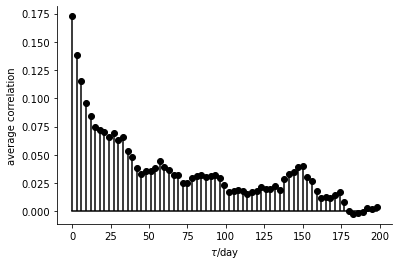

In [9]:
step = 3
plt.stem(range(0,n,step), np.array(l_corr_list[::step]), linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$/day')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()

In [10]:
new_df_vol = hk_100.pivot(index='date', columns='id', values='vol').fillna(0)
new_df_resi = new_df.copy()
aver =  np.array(new_df_vol.T.mean()).reshape(-1,1)
for name in new_df_vol.columns:
    fit_y = new_df_vol[name]
    fit_x = aver
    regression_model = LinearRegression()
    regression_model.fit(fit_x, fit_y)

    # 计算拟合后的残差
    residuals = fit_y - regression_model.predict(fit_x)
    new_df_resi[name] = residuals

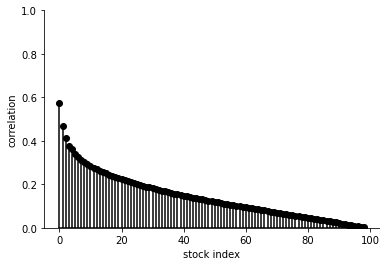

0.14469580837192608


In [11]:
stocks = new_df_resi.columns
corr_list_ = [0 for i in stocks]
for i in range(len(stocks)):
    corr_list = [abs(pearsonr(new_df_resi[stocks[i]],new_df_resi[stocks[j]])[0]) for j in range(len(stocks))]
    (corr_list).sort(reverse= True)
    for j in range(len(stocks)):
        corr_list_[j] += corr_list[j]/len(stocks)
plt.stem(range(len(stocks)-1), corr_list_[1:], linefmt='black', markerfmt='ko', basefmt='k-')
ax = plt.gca()

# 隐藏右边和上边的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('stock index')
plt.ylabel('correlation')
plt.ylim(0,1)
plt.show()

print(sum(corr_list_[1:])/(len(corr_list_)-1))

In [12]:
n = 200
l_corr_list = [0 for i in range(n)]
l_corr_list_ = [0 for i in range(n)]
#bestname = new_df.columns
test_names = bestname[:]

for name in tqdm(test_names):
    small_df = hk_100[hk_100['id']==name].copy().dropna()
    series = pd.Series(small_df['vol'].fillna(0))

    autocorrelation = series.autocorr()

    # 计算不同滞后阶数的自相关系数
    lags = range(n)
    for lag in lags:
        l_corr_list[lag] += series.autocorr(lag)/len(test_names)


  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:08<00:00, 11.77it/s]


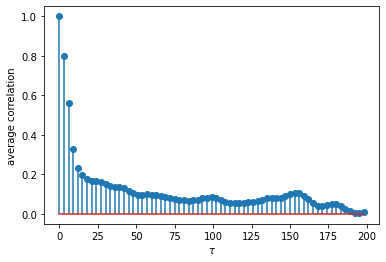

In [13]:
step = 3
plt.stem(range(0,n,step), np.array(l_corr_list[::step]))
#plt.scatter(range(n), np.array(l_corr_list_),c='r')
plt.xlabel(r'$ \tau$')
plt.ylabel('average correlation')
#plt.title(r'relation between corr and $\tau$')
plt.show()